Experience from this notebook:
- Neural networks are really inconsistent in performance, therefore they aren't applicable for this problem
- Bagging without Lasso > Bagging with Lasso
- RF without Lasso > RF with Lasso
- Ada with resampled > Ada without Lasso > Ada with Lasso
- GB with resampled (slightly) > GB without Lasso > GB with Lasso

# Import and Prepare

In [ ]:
import os
from copy import deepcopy

import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import fbeta_score
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample

import matplotlib.pyplot as plt

In [ ]:
CSV_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/AppStats Project/data.csv'

TEST_SIZE = 0.15
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

In [ ]:
f2_score = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2)

In [ ]:
def print_and_plot_results(params, test_res_list, train_res_list):
    for index, (param, test_res, train_res) in \
            enumerate(zip(params, test_res_list, train_res_list)):
        print(f'\
{param}, \
test={test_res}, \
train={train_res}')

    plt.plot(params, test_res_list)
    plt.plot(params, train_res_list)

In [ ]:
df = pd.read_csv(CSV_FILE_PATH)
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [ ]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


# Train test split

In [ ]:
y = (df['Bankrupt?']).to_numpy()
y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
X = df.drop('Bankrupt?', axis=1, inplace=False).to_numpy()
X

array([[0.37059426, 0.42438945, 0.40574977, ..., 0.56405011, 1.        ,
        0.01646874],
       [0.46429094, 0.53821413, 0.51673002, ..., 0.57017495, 1.        ,
        0.02079431],
       [0.42607127, 0.49901875, 0.47229509, ..., 0.56370608, 1.        ,
        0.01647411],
       ...,
       [0.47272461, 0.533744  , 0.52063815, ..., 0.5651584 , 1.        ,
        0.09764874],
       [0.50626432, 0.5599106 , 0.55404465, ..., 0.56530151, 1.        ,
        0.04400945],
       [0.49305319, 0.57010467, 0.54954762, ..., 0.56516694, 1.        ,
        0.23390224]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y,
        random_state=RANDOM_STATE)
print(  X_train.shape,
        X_test.shape,
        y_train.shape,
        y_test.shape
)

(5796, 95) (1023, 95) (5796,) (1023,)


(array([0, 1]), array([6599,  220]))
(array([0, 1]), array([5609,  187]))
(array([0, 1]), array([990,  33]))


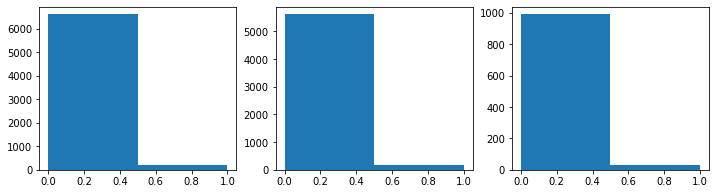

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(12)

ax[0].hist(y, bins=2)
ax[1].hist(y_train, bins=2)
ax[2].hist(y_test, bins=2)

print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

# SMOTE over-sample 

In [ ]:
X_train, y_train = SMOTE(
    random_state=RANDOM_STATE).fit_resample(X_train, y_train)

(array([0, 1]), array([5609, 5609]))


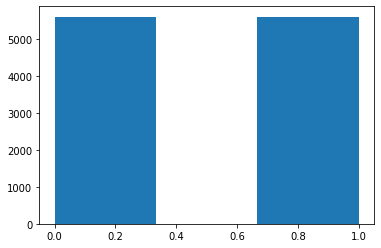

In [ ]:
plt.hist(y_train, bins=3)
print(np.unique(y_train, return_counts=True))

# Lasso regress and Feature select

In [ ]:
lasso = Lasso(random_state=RANDOM_STATE)
lasso.fit(X_train, y_train)
lasso.coef_

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -7.97129697e-12, -2.12024851e-11,
       -0.00000000e+00, -4.02456412e-10, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -8.87673152e-11, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -2.83152612e-11,  1.32084569e-10, -0.00000000e+00, -0.00000000e+00,
       -1.64053739e-10,  1.56588945e-11, -0.00000000e+00,  6.22221909e-11,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -1.00454744e-10, -7.98763490e-11, -5.48423293e-12,
        2.61321792e-11,  0.00000000e+00, -5.55452190e-11, -0.00000000e+00,
       -6.45969967e-11, -

In [ ]:
zero_filter = lasso.coef_ != 0
zero_filter

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True,  True, False, False,  True,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True, False,  True, False,  True, False,
       False, False, False,  True,  True, False, False, False,  True,
       False, False, False,  True, False, False, False,  True,  True,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False])

In [ ]:
sum(zero_filter)  # number of True values

24

In [ ]:
X_train_filtered = X_train.transpose()
X_train_filtered = X_train_filtered[zero_filter]
X_train_filtered = X_train_filtered.transpose()
print(X_train_filtered.shape)
X_train_filtered

(11218, 24)


array([[1.31709967e-04, 1.02000000e+09, 1.94019402e-04, ...,
        1.27000000e+09, 2.60621223e-01, 3.17818677e-03],
       [7.18000000e+09, 0.00000000e+00, 6.27062706e-04, ...,
        4.01000000e+09, 6.08504883e-01, 9.39829344e-04],
       [5.40000000e+09, 3.34000000e+09, 9.80098010e-04, ...,
        3.82000000e+08, 1.59617057e-01, 4.70266612e-03],
       ...,
       [4.25115704e-04, 6.06351465e+09, 2.15967077e-04, ...,
        9.17399975e+09, 2.10427398e-01, 7.47651940e-03],
       [6.61405439e+09, 1.44541376e+09, 2.12245257e-04, ...,
        3.73328506e+09, 6.15768778e-02, 8.02418531e-03],
       [3.52104503e-04, 7.01027237e+09, 4.15054267e-04, ...,
        2.27797597e-04, 2.41321537e-01, 1.67625217e-03]])

In [ ]:
X_test_filtered = X_test.transpose()
X_test_filtered = X_test_filtered[zero_filter]
X_test_filtered = X_test_filtered.transpose()
print(X_test_filtered.shape)
X_test_filtered

(1023, 24)


array([[5.35000000e+09, 9.17000000e+08, 2.20022002e-04, ...,
        5.30000000e+08, 9.04357635e-03, 1.63761936e-03],
       [1.23037230e-04, 3.36000000e+09, 1.13111311e-03, ...,
        9.76000000e+09, 1.12865573e-01, 2.28457792e-03],
       [9.56000000e+09, 1.53000000e+09, 5.36053605e-04, ...,
        7.97000000e+07, 5.05894800e-01, 4.58197266e-03],
       ...,
       [1.33213241e-04, 1.15000000e+08, 3.33033303e-04, ...,
        2.19000000e+09, 4.07154619e-01, 4.46109855e-04],
       [1.17717951e-04, 2.72000000e+08, 4.70047005e-04, ...,
        5.98000000e+08, 1.42206746e-01, 9.89225520e-03],
       [1.62700547e-04, 0.00000000e+00, 3.56035604e-04, ...,
        6.95504468e-04, 1.89392530e-01, 1.28476201e-03]])

# Resample the oversampled sets

In [ ]:
X_resampled, y_resampled = resample(X_train, y_train,
                                    stratify=y_train,
                                    n_samples=y_train.shape[0] * 2,
                                    random_state=RANDOM_STATE
                                    )

# Neural network

In [ ]:
WIDTHS = np.unique(np.logspace(0, np.log10(100), num=15, base=10, dtype=int))

In [ ]:
def nn(X_to_train, y_to_train, X_to_test, y_to_test):
    test_f2 = []
    train_f2 = []

    for width in WIDTHS:
        clf = MLPClassifier(
            hidden_layer_sizes=(width, width), random_state=RANDOM_STATE)
        clf.fit(X_to_train, y_to_train)

        y_to_test_pred = clf.predict(X_to_test)
        y_to_train_pred = clf.predict(X_to_train)

        test_f2.append(f2_score(y_true=y_to_test, y_pred=y_to_test_pred))
        train_f2.append(f2_score(y_true=y_to_train, y_pred=y_to_train_pred))

    print_and_plot_results(WIDTHS, test_f2, train_f2)

## Neural network with Lasso

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


1, test=0.1483812949640288, train=0.8386469091453375
2, test=0.14653641207815277, train=0.837764368502808
3, test=0.14634146341463417, train=0.7858685590867017
5, test=0.13946280991735538, train=0.7425851798152993
7, test=0.14257620452310715, train=0.8403862018393474
10, test=0.14362657091561937, train=0.585276553391156
13, test=0.16129032258064516, train=0.38098300044206884
19, test=0.24539877300613497, train=0.7847184501176897
26, test=0.04484304932735426, train=0.5815213185792772
37, test=0.23102310231023102, train=0.862891737891738
51, test=0.10416666666666669, train=0.34989227709645343
71, test=0.15550239234449764, train=0.9410943986932554
100, test=0.2056962025316455, train=0.9278241943410797


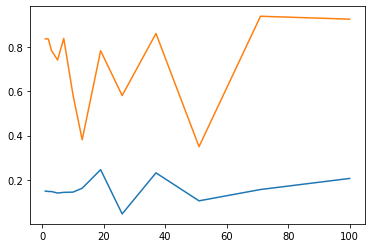

In [ ]:
nn(X_train_filtered, y_train, X_test_filtered, y_test)

## Neural network without Lasso

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


1, test=0.0, train=0.0
2, test=0.0, train=0.0
3, test=0.15151515151515152, train=0.5786706590996136
5, test=0.1388888888888889, train=0.8343067661065683
7, test=0.1359927470534905, train=0.8397312859884837
10, test=0.06868131868131869, train=0.42443223302463207
13, test=0.22546419098143236, train=0.6086409240679723
19, test=0.14749262536873156, train=0.8722919042189281
26, test=0.13636363636363638, train=0.8376050121030898
37, test=0.23131672597864766, train=0.8570298738181689
51, test=0.16085790884718498, train=0.9069212410501193
71, test=0.23041474654377878, train=0.8414428916367894
100, test=0.17676767676767677, train=0.8405844990270588


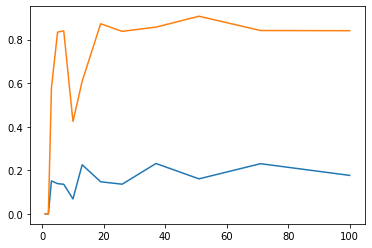

In [ ]:
nn(X_train, y_train, X_test, y_test)

## Neural network with resampled

1, test=0.14285714285714288, train=0.8333333333333334
2, test=0.14285714285714288, train=0.8333333333333334
3, test=0.14798206278026907, train=0.8381774981694287
5, test=0.14209591474245115, train=0.8373141458171613
7, test=0.13938848920863306, train=0.8395826784618378
10, test=0.11093502377179082, train=0.5993375742600283
13, test=0.06637168141592921, train=0.2611362369122111
19, test=0.1639344262295082, train=0.8745272711992604
26, test=0.18739352640545143, train=0.9004676681043742
37, test=0.26104417670682734, train=0.8447596389590106
51, test=0.14184397163120566, train=0.9474716421074948
71, test=0.18041237113402062, train=0.8910603890570896
100, test=0.2577319587628866, train=0.9489711644906782


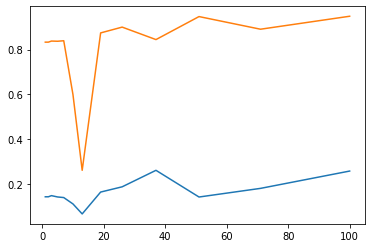

In [ ]:
nn(X_resampled, y_resampled, X_test, y_test)

# Bagging

In [ ]:
N_ESTIMATORS_LIST = \
    np.unique(np.logspace(0, np.log10(100), num=15, base=10, dtype=int))

In [ ]:
def bagging(X_to_train, y_to_train, X_to_test, y_to_test):
    test_f2 = []
    train_f2 = []

    for n_estimators in N_ESTIMATORS_LIST:
        clf = BaggingClassifier(n_estimators=n_estimators,
                                random_state=RANDOM_STATE)
        clf.fit(X_to_train, y_to_train)

        y_to_test_pred = clf.predict(X_to_test)
        y_to_train_pred = clf.predict(X_to_train)

        test_f2.append(f2_score(y_true=y_to_test, y_pred=y_to_test_pred))
        train_f2.append(f2_score(y_true=y_to_train, y_pred=y_to_train_pred))

    print_and_plot_results(N_ESTIMATORS_LIST, test_f2, train_f2)

## Bagging with Lasso

1, test=0.2954545454545454, train=0.98366780529462
2, test=0.28409090909090906, train=0.9746871750743967
3, test=0.26960784313725494, train=0.995333262085426
5, test=0.40404040404040403, train=0.9980047031996009
7, test=0.43589743589743585, train=0.9992516303766794
10, test=0.4076086956521739, train=0.9996079270031365
13, test=0.3926701570680628, train=0.9993941985603307
19, test=0.38860103626943004, train=0.9997861038822144
26, test=0.40106951871657753, train=0.9999643442915209
37, test=0.374331550802139, train=1.0
51, test=0.39473684210526316, train=1.0
71, test=0.4032258064516129, train=1.0
100, test=0.3846153846153846, train=1.0


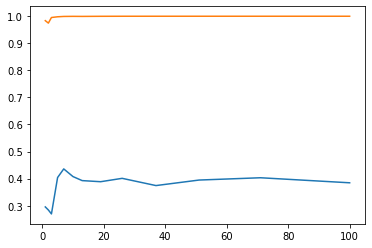

In [ ]:
bagging(X_train_filtered, y_train, X_test_filtered, y_test)

## Bagging without Lasso

1, test=0.4439252336448599, train=0.9832151384483804
2, test=0.3313253012048193, train=0.9728798966853207
3, test=0.37634408602150543, train=0.9964387464387464
5, test=0.44041450777202074, train=0.9976835352815397
7, test=0.44270833333333326, train=0.9987884834663626
10, test=0.37142857142857144, train=0.9992513635877509
13, test=0.41666666666666663, train=0.9996434937611409
19, test=0.41666666666666663, train=0.9998217151007309
26, test=0.4, train=0.9998573669947225
37, test=0.4189944134078212, train=1.0
51, test=0.41208791208791207, train=1.0
71, test=0.41666666666666663, train=1.0
100, test=0.3735632183908046, train=1.0


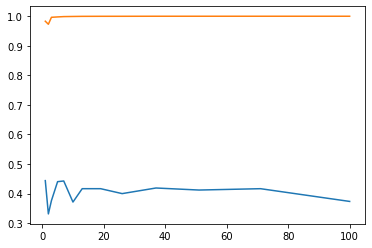

In [ ]:
bagging(X_train, y_train, X_test, y_test)

# Random forest

In [ ]:
N_ESTIMATORS_LIST = \
    np.unique(np.logspace(0, np.log10(100), num=15, base=10, dtype=int))

In [ ]:
def rf(X_to_train, y_to_train, X_to_test, y_to_test):
    test_f2 = []
    train_f2 = []

    for n_estimators in N_ESTIMATORS_LIST:
        clf = RandomForestClassifier(n_estimators=n_estimators,
                                     random_state=RANDOM_STATE)
        clf.fit(X_to_train, y_to_train)

        y_to_test_pred = clf.predict(X_to_test)
        y_to_train_pred = clf.predict(X_to_train)

        test_f2.append(f2_score(y_true=y_to_test, y_pred=y_to_test_pred))
        train_f2.append(f2_score(y_true=y_to_train, y_pred=y_to_train_pred))

    print_and_plot_results(N_ESTIMATORS_LIST, test_f2, train_f2)

## Random forest with Lasso

1, test=0.42792792792792794, train=0.9748494887962666
2, test=0.3125, train=0.9625899280575542
3, test=0.40816326530612246, train=0.9942614770459084
5, test=0.41666666666666663, train=0.9979324849392222
7, test=0.45977011494252873, train=0.9991445070221714
10, test=0.39156626506024095, train=0.9994651453021929
13, test=0.4335260115606936, train=0.999857392420407
19, test=0.4571428571428572, train=0.9999286911256104
26, test=0.39156626506024095, train=1.0
37, test=0.4069767441860465, train=1.0
51, test=0.4093567251461988, train=1.0
71, test=0.40462427745664736, train=1.0
100, test=0.4069767441860465, train=1.0


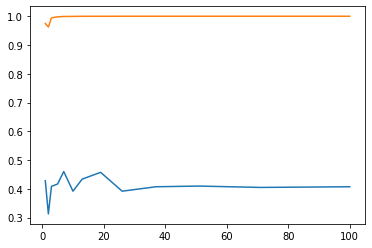

In [ ]:
rf(X_train_filtered, y_train, X_test_filtered, y_test)

## Random forest without Lasso

1, test=0.4377880184331797, train=0.9831051040369909
2, test=0.47337278106508873, train=0.9738210507441277
3, test=0.532994923857868, train=0.9958351131994873
5, test=0.5235602094240838, train=0.9979339578954867
7, test=0.5053191489361702, train=0.9988238648513793
10, test=0.4571428571428572, train=0.9994652406417113
13, test=0.4891304347826087, train=0.9996078571173933
19, test=0.5405405405405405, train=0.9997504189396372
26, test=0.5248618784530387, train=0.9998573669947225
37, test=0.5248618784530387, train=1.0
51, test=0.521978021978022, train=1.0
71, test=0.5027932960893854, train=1.0
100, test=0.5084745762711864, train=1.0


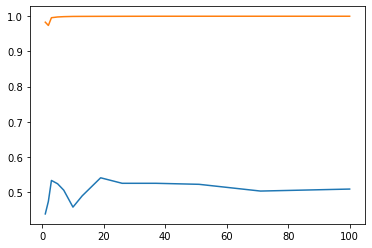

In [ ]:
rf(X_train, y_train, X_test, y_test)

# AdaBoost

In [ ]:
N_ESTIMATORS_LIST = \
    np.unique(np.logspace(0, np.log10(100), num=15, base=10, dtype=int))

In [ ]:
def ada(X_to_train, y_to_train, X_to_test, y_to_test):
    test_f2 = []
    train_f2 = []

    for n_estimators in N_ESTIMATORS_LIST:
        clf = AdaBoostClassifier(n_estimators=n_estimators,
                                     random_state=RANDOM_STATE)
        clf.fit(X_to_train, y_to_train)

        y_to_test_pred = clf.predict(X_to_test)
        y_to_train_pred = clf.predict(X_to_train)

        test_f2.append(f2_score(y_true=y_to_test, y_pred=y_to_test_pred))
        train_f2.append(f2_score(y_true=y_to_train, y_pred=y_to_train_pred))

    print_and_plot_results(N_ESTIMATORS_LIST, test_f2, train_f2)

## AdaBoost with Lasso

1, test=0.3234501347708895, train=0.8581396164229866
2, test=0.3234501347708895, train=0.8581396164229866
3, test=0.3993610223642172, train=0.8822491263986446
5, test=0.3503184713375796, train=0.8778288543140028
7, test=0.4323308270676692, train=0.88316188026861
10, test=0.39033457249070636, train=0.8962163317657119
13, test=0.39772727272727265, train=0.9023346996970238
19, test=0.46875, train=0.9133176571184267
26, test=0.5284552845528455, train=0.9144010574827622
37, test=0.5286343612334802, train=0.9218515608257732
51, test=0.4585152838427949, train=0.9299835843266007
71, test=0.4398148148148148, train=0.9400292366384996
100, test=0.430622009569378, train=0.9499554764024934


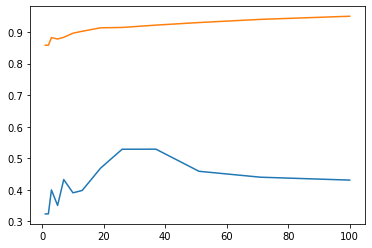

In [ ]:
ada(X_train_filtered, y_train, X_test_filtered, y_test)

## AdaBoost without Lasso

1, test=0.3485254691689008, train=0.8955975279494479
2, test=0.3485254691689008, train=0.8955975279494479
3, test=0.4078014184397163, train=0.8602150537634408
5, test=0.46332046332046334, train=0.8927616807441462
7, test=0.4591836734693877, train=0.9225053450632646
10, test=0.43893129770992373, train=0.9168228595678466
13, test=0.4365079365079365, train=0.9215762916637054
19, test=0.48319327731092443, train=0.928464871776657
26, test=0.5000000000000001, train=0.9410406677321969
37, test=0.47085201793721976, train=0.949529056335525
51, test=0.502283105022831, train=0.9571519931784268
71, test=0.48076923076923067, train=0.9686291209766136
100, test=0.4656862745098039, train=0.9731746313732456


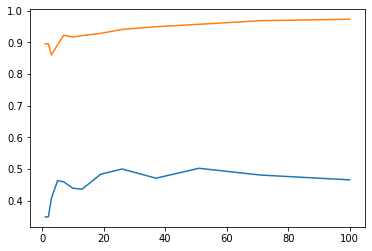

In [ ]:
ada(X_train, y_train, X_test, y_test)

## AdaBoost with resampled

1, test=0.34946236559139787, train=0.8956376829204784
2, test=0.4861111111111111, train=0.8386890633558519
3, test=0.4166666666666667, train=0.8863330022701478
5, test=0.4428044280442805, train=0.9023450675471765
7, test=0.43252595155709334, train=0.9211128317026818
10, test=0.4509803921568628, train=0.917106174417985
13, test=0.44897959183673464, train=0.9244287288105477
19, test=0.42918454935622313, train=0.9321792659277314
26, test=0.49327354260089684, train=0.9452590420332356
37, test=0.5275229357798165, train=0.9521650217835868
51, test=0.5140186915887851, train=0.9561437815544338
71, test=0.5263157894736842, train=0.968360839210531
100, test=0.5121951219512195, train=0.9767429464856797


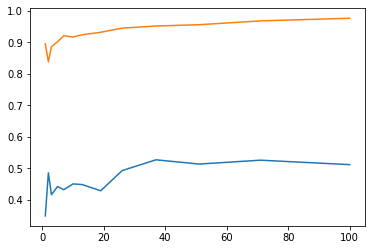

In [ ]:
ada(X_resampled, y_resampled, X_test, y_test)

# Gradient Boosting

In [ ]:
N_ESTIMATORS_LIST = \
    np.unique(np.logspace(0, np.log10(100), num=15, base=10, dtype=int))

In [ ]:
def gb(X_to_train, y_to_train, X_to_test, y_to_test):
    test_f2 = []
    train_f2 = []

    for n_estimators in N_ESTIMATORS_LIST:
        clf = GradientBoostingClassifier(n_estimators=n_estimators,
                                         random_state=RANDOM_STATE)
        clf.fit(X_to_train, y_to_train)

        y_to_test_pred = clf.predict(X_to_test)
        y_to_train_pred = clf.predict(X_to_train)

        test_f2.append(f2_score(y_true=y_to_test, y_pred=y_to_test_pred))
        train_f2.append(f2_score(y_true=y_to_train, y_pred=y_to_train_pred))

    print_and_plot_results(N_ESTIMATORS_LIST, test_f2, train_f2)

## Gradient Boosting with Lasso

1, test=0.4000000000000001, train=0.9078757606669247
2, test=0.48117154811715485, train=0.8701064405556559
3, test=0.43046357615894043, train=0.9024019243694507
5, test=0.4779411764705882, train=0.9014906257782204
7, test=0.4814814814814815, train=0.9036573217589298
10, test=0.5, train=0.9058668377530653
13, test=0.48638132295719844, train=0.9121814039584224
19, test=0.5220883534136547, train=0.9241293532338308
26, test=0.5241935483870968, train=0.93569223125244
37, test=0.4958677685950412, train=0.9470006030721203
51, test=0.5319148936170213, train=0.9529645813350386
71, test=0.5296610169491526, train=0.9605885070542663
100, test=0.5454545454545454, train=0.9709980096673299


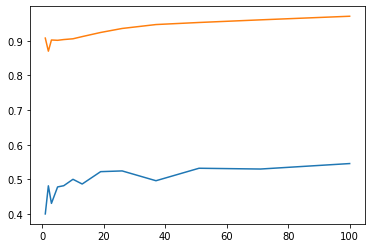

In [ ]:
gb(X_train_filtered, y_train, X_test_filtered, y_test)

## Gradient Boosting without Lasso

1, test=0.4844961240310077, train=0.9085409252669039
2, test=0.4938271604938272, train=0.8987314556009461
3, test=0.47709923664122134, train=0.9126927723687015
5, test=0.49019607843137253, train=0.9147361303868189
7, test=0.4940711462450593, train=0.9153000604745475
10, test=0.4940711462450593, train=0.9188824114886962
13, test=0.4940711462450593, train=0.9339238263950401
19, test=0.5040322580645161, train=0.942557637142756
26, test=0.5020080321285141, train=0.9505521732974657
37, test=0.5394190871369294, train=0.9596854187331728
51, test=0.5579399141630902, train=0.9692956050571944
71, test=0.5580357142857143, train=0.9766774182114628
100, test=0.5140186915887851, train=0.9832138547803251


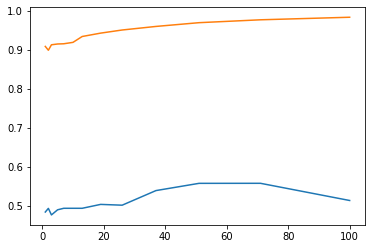

In [ ]:
gb(X_train, y_train, X_test, y_test)

## Gradient Boosting with resampled

1, test=0.48828125, train=0.9137952459569333
2, test=0.48638132295719844, train=0.9144956342727338
3, test=0.49019607843137253, train=0.9148150121667467
5, test=0.5122950819672131, train=0.9122331896090939
7, test=0.502092050209205, train=0.9115967885816234
10, test=0.4980079681274901, train=0.9278341373439274
13, test=0.5081300813008129, train=0.9343367193178393
19, test=0.5040322580645161, train=0.9449487710357276
26, test=0.5327868852459017, train=0.9530719139297849
37, test=0.5416666666666666, train=0.959399135548785
51, test=0.5652173913043478, train=0.9708161202815553
71, test=0.5752212389380531, train=0.9785751024244895
100, test=0.573394495412844, train=0.9848108012080299


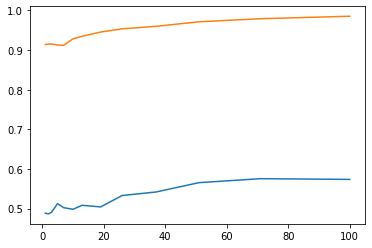

In [ ]:
gb(X_resampled, y_resampled, X_test, y_test)